# AA3 - Práctica 1

**Andrés Lires Saborido - andres.lires@udc.es**

### Descripción

En esta práctica deberás hacer un agente que, haciendo aprendizaje por refuerzo, sea capaz de manejar con destreza el entorno ***Pendulum-v1*** de *OpenGym*. Este entorno simula un péndulo al qsaue se le puede aplicar una fuerza rotacional. El objetivo es mantener el péndulo lo más cercano que sea posible a la vertical por encima de su eje.

### Consejos:

- Si quieres renderizar el entorno, utiliza Jupyter, no Google Colab. En Google Colab no podrás renderizar el entorno adecuadamente. (Puedes utilizar esta [respuesta](https://stackoverflow.com/a/52600239) pero el resultado es extremadamente lento). Utiliza `render_mode='human'` y render ya mostrará la ventana (no hay que hacer `imshow` ni `plt.show()`).

- Limita la duración de los episodios a 10seg con `env._max_episode_steps = 600`

- Deberás representar el estado del entorno a partir de las observaciones (tomadas al hacer `env.reset` o `env.step`). Estas estadoervaciones toman valores continuos (puedes ver la [descripción detallada](https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py)). Se recomienda discretizar estos valores, por ejemplo, en 20 intervalos y tomar el número de intervalo como la representación.

- Las acciones que se pueden efectuar también se expresan como valores continuos. Discretízalas en, por ejemplo, 20 intervalos.

- Puedes utilizar cualquier otra codificación para estados y/o acciones. Si decides usar otra, haz experimentos para comparar con la codificación propuesta.

### Trabajo a realizar

1. Implementación de los algoritmos

    Deberás implementar los siguientes algoritmos:

    - MonteCarlo control (lab5)
    - SARSA (lab6)
    - Q-learning (lab6)
    - Expected SARSA (muy similar a Q-learning; ver transparencias de teoría)

2. Ajuste de parámetros

    Toma GAMMA=0.9. Encuentra valores para otros parámetros que ofrezcan buenos resultados. No es necesario realizar una búsqueda exhaustiva de parámetros; intenta razonar qué valores tiene sentido probar.
    
    Realiza los experimentos que consideres necesarios para contestar a las siguientes preguntas:

3. ¿Qué algoritmo obtiene una política determinista más efectiva?

4. ¿Qué algoritmo obtiene mejor rendimiento como algoritmo de control, es decir, mayores retornos mientras sigue aprendiendo?

5. Si introducimos perturbaciones, ¿qué algoritmo funciona mejor? ¿Cómo podemos adaptar el aprendizaje para que funcione mejor en este caso?

    - Las perturbaciones consisten en que, en cada paso haya una probabilidad de 0.025 de que la acción que se ejecute sea [-2.0] y una probabilidad de 0.025 de que la acción que se ejecute sea [2.0] (el resto de veces se realizará la acción que determine el agente). 

### Resolución práctica

Importamos librerías necesarias:

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Cargamos el entorno pendulum v1 de gym
# env = gym.make('Pendulum-v1', render_mode='human')
env = gym.make('Pendulum-v1')
env._max_episode_steps = 600  # Limitar episodios a 10 segundos

# Inicializamos el entorno
entorno_inicial, _ = env.reset()

Discretizamos el número de acciones:

In [4]:
# Acciones posibles
print("Acciones posibles: ", env.action_space)

Acciones posibles:  Box(-2.0, 2.0, (1,), float32)


In [5]:
NUM_ACCIONES = 20 # Número de intervalos en los que dividimos el espacio de acciones

ACCIONES = list(np.around(np.arange(-2, 2, 4/NUM_ACCIONES), 2))

# Observamos el espacio de acciones discretizado
print("Espacio de acciones discretizado:\n", ACCIONES)

Espacio de acciones discretizado:
 [-2.0, -1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2, -0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]


Discretizamos las observaciones:

In [6]:
# Espacio de observaciones
print("Espacio de observaciones: ", env.observation_space)

Espacio de observaciones:  Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)


In [ ]:
# Función para discretizar los estados
# Sabemos que el estado es un array de 3 elementos:

# | Num | estado           | Min  | Max |
# |-----|------------------|------|-----|
# | 0   | x = cos(theta)   | -1.0 | 1.0 |
# | 1   | y = sin(theta)   | -1.0 | 1.0 |
# | 2   | Angular Velocity | -8.0 | 8.0 |

NUM_INTERVALOS = 20

def discretizar(valor, min_val=-2, max_val=2, bins=NUM_INTERVALOS):
    tamaño_intervalo = (max_val - min_val) / bins # Calculamos el tamaño de cada intervalo
    indice_intervalo = int((valor - min_val) / tamaño_intervalo) # Calculamos el índice del intervalo correspondiente
    return round(max(0, min(bins - 1, indice_intervalo)), 2)

def discretizar_estado(estado, bins=NUM_INTERVALOS):
    # Discretizamos cada componente del estado
    # Estado: [cos(theta), sin(theta), angular_velocity]
    cos = discretizar(estado[0], -1, 1) 
    sin = discretizar(estado[1], -1, 1)
    ang_vel = discretizar(estado[2], -8, 8)
    return [cos, sin, ang_vel]

# Probamos la función de discretización
print("Estado inicial original: ", entorno_inicial)
print("Estado inicial discretizado: ", discretizar_estado(entorno_inicial))


Estado inicial original:  [-0.606539  -0.7950537  0.6115384]
Estado inicial discretizado:  [3, 2, 10]


### Montecarlo

Creamos una función auxiliar (sample_policy) para obtener una acción a partir de la política.

In [ ]:
def sample_policy(estado, politica, perturbation=False):

    # Estado discretizado
    estado = discretizar_estado(estado)
    probs = politica[tuple(estado)]

    accion = np.random.choice(ACCIONES, p=probs)  # Valor de la acción

    if perturbation:
        random = np.random.random()
        if random < 0.025: # 2.5% de probabilidad de acción aleatoria
            accion = -2.0
        elif random > 0.975: # 2.5% de probabilidad de acción aleatoria
            accion = 1.8   
     
    indice_accion = ACCIONES.index(accion) # Índice de la acción

    return indice_accion, [accion]

Creamos otra función (simula_episodio) para simular un episodio (600 pasos) y obtener las recompensas con una política dada.

In [9]:
def simula_episodio(env, politica, perturbation=False):
    episode = []
    estado, _ = env.reset() # Partimos de un estado inicial
    retorno = 0
    
    for _ in range(600):
        indice_accion, accion = sample_policy(estado, politica, perturbation) # Elegimos una acción
        estado, recompensa, _, _, _ = env.step(accion) # Aplicamos la acción y obtenemos el nuevo estado y la recompensa
        retorno += recompensa
        episode.append((estado, indice_accion, accion, recompensa))
    
    return episode, retorno

In [ ]:
GAMMA = 0.9

### VAMOS SIGUIENDO EL PSEUDOCÓDIGO DEL LAB 5

def control_mc(env, max_episodes, epsilon=0.2, alpha=False, perturbation=False):
    # Inicialización de estructuras de datos
    qsa = np.zeros((NUM_INTERVALOS, NUM_INTERVALOS, NUM_INTERVALOS, NUM_ACCIONES))
    politica = np.ones((NUM_INTERVALOS, NUM_INTERVALOS, NUM_INTERVALOS, NUM_ACCIONES)) / NUM_ACCIONES
    
    retornos = np.zeros_like(qsa)
    retornos_count = np.zeros_like(qsa)
    avg_retornos = []
    resultados = []
    
    # Repetir para cada episodio
    for episode_num in range(max_episodes):
        # Generar episodio usando la función simula_episodio
        episode, retorno_episodio = simula_episodio(env, politica, perturbation)
        
        # Inicializar G
        G = 0 
        visited = set()
        
        # Para cada paso del episodio en orden inverso (600 pasos)
        for t in reversed(range(len(episode))):
            estado, indice_accion, accion, ret = episode[t]
            estado_discreto = discretizar_estado(estado)
            estado_accion = (tuple(estado_discreto), indice_accion)
            
            # Actualizar G
            G = GAMMA * G + ret
            
            # Si el estado-acción no ha sido visitado en este episodio
            if estado_accion not in visited:
                # Añadir estado-acción a visitados
                visited.add(estado_accion) 
                
                # Añadir a retornos
                retornos[estado_accion[0]][estado_accion[1]] += G
                retornos_count[estado_accion[0]][estado_accion[1]] += 1
                
                # Actualizar qsa
                qsa[estado_accion[0]][estado_accion[1]] = (retornos[estado_accion[0]][estado_accion[1]] / retornos_count[estado_accion[0]][estado_accion[1]])
                
                # Elegir mejor acción
                mejores_indices = np.where(qsa[estado_accion[0]] == qsa[estado_accion[0]][np.argmax(qsa[estado_accion[0]])])[0]
                mejor_accion = np.random.choice(mejores_indices)
                
                # Actualizar política
                politica[estado_accion[0]] = epsilon / NUM_ACCIONES
                politica[estado_accion[0]][mejor_accion] = 1 - epsilon + epsilon / NUM_ACCIONES
        
        # Ver el rendimiento conforme sigue aprendiendo
        avg_retornos.append(retorno_episodio)
        if len(avg_retornos) > 100:
            print(f'Iteración:', episode_num, '| Retorno medio últimas 100:', np.mean(avg_retornos[-100:]))
            resultados.append(np.mean(avg_retornos[-100:]))            
    
    return politica, resultados

In [11]:
env = gym.make('Pendulum-v1')

num_episodios = 3000
politica_montecarlo, resultados_montecarlo = control_mc(env, num_episodios,  epsilon=0.1)

Iteración: 100 | Retorno medio últimas 100: -3716.3338993438942
Iteración: 101 | Retorno medio últimas 100: -3736.659493898825
Iteración: 102 | Retorno medio últimas 100: -3737.3668457169983
Iteración: 103 | Retorno medio últimas 100: -3729.8414838925673
Iteración: 104 | Retorno medio últimas 100: -3729.0780399563732
Iteración: 105 | Retorno medio últimas 100: -3735.5639419874688
Iteración: 106 | Retorno medio últimas 100: -3726.5528783483383
Iteración: 107 | Retorno medio últimas 100: -3732.543510494078
Iteración: 108 | Retorno medio últimas 100: -3731.4770054478013
Iteración: 109 | Retorno medio últimas 100: -3730.685821165991
Iteración: 110 | Retorno medio últimas 100: -3738.865154570091
Iteración: 111 | Retorno medio últimas 100: -3741.159107051537
Iteración: 112 | Retorno medio últimas 100: -3738.5368565156527
Iteración: 113 | Retorno medio últimas 100: -3738.577699089003
Iteración: 114 | Retorno medio últimas 100: -3728.7356482344644
Iteración: 115 | Retorno medio últimas 100: -3

Creamos una función para evaluar la política:

In [12]:
def comprueba_politica(env, politica:np.ndarray) -> None:
    recompensas = []
    for i in range(200):
        _, ret = simula_episodio(env, politica)
        recompensas.append(ret)

    plt.hist(recompensas)
    plt.show()

    plt.boxplot(recompensas)
    plt.show()

    print(f'Recompensa media: {np.mean(recompensas)}')

    return np.mean(recompensas)

Mostramos como se comporta el péndulo con la política Montecarlo:

In [22]:
def muestra_ejecucion(env, politica:np.ndarray) -> None:
    for i in range(3):
        _, ret = simula_episodio(env, politica)

In [43]:
env_render = gym.make('Pendulum-v1', render_mode="human")
muestra_ejecucion(env_render, politica_montecarlo)

Comprobamos la política obtenida con Montecarlo:

Política aleatoria:


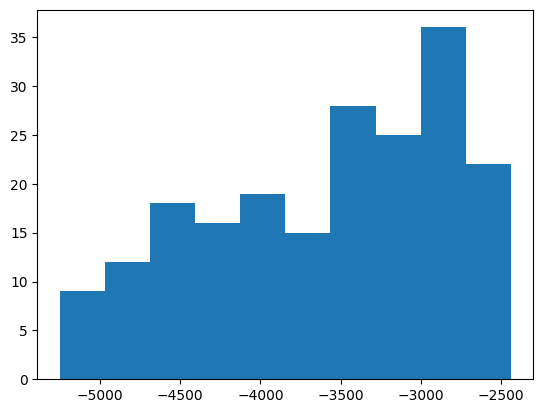

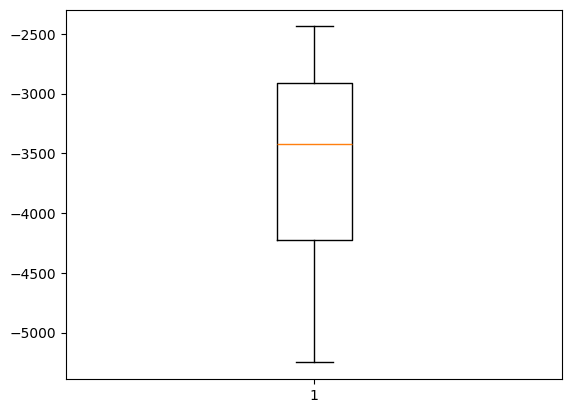

Recompensa media: -3599.85246874635
Política Monte Carlo:


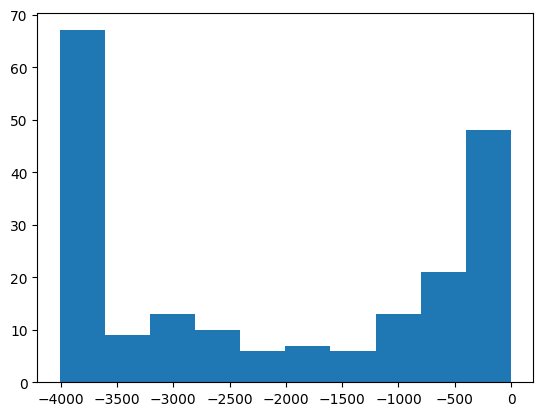

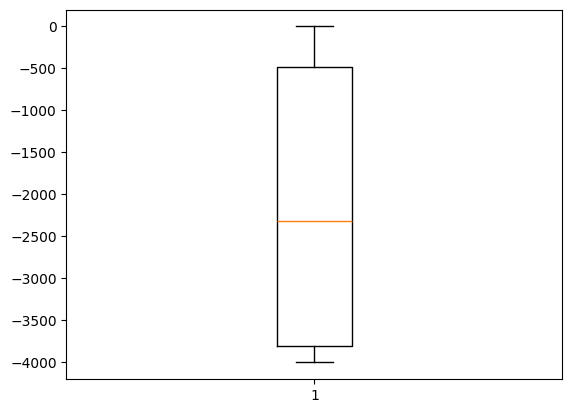

Recompensa media: -2099.777539991975


In [ ]:
print("Política aleatoria:")
comprueba_politica(env, np.ones((NUM_INTERVALOS, NUM_INTERVALOS, NUM_INTERVALOS, NUM_ACCIONES)) / NUM_ACCIONES)
print("Política Monte Carlo:")
montecarlo_reward = comprueba_politica(env, politica_montecarlo)

#### SARSA

Función auxiliar (epsilon_greedy) para obtener una acción a partir de la política.

In [ ]:
GAMMA = 0.9
NUM_ACCIONES = 20

def epsilon_greedy_policy(qsa, estado, epsilon, perturbation=False):

    estado = tuple(estado)
    
    # Selección ε-greedy estándar
    if np.random.random() < epsilon:
        indice_accion = np.random.randint(NUM_ACCIONES)
    else:
        max_q = np.max(qsa[estado])
        best_actions = np.where(qsa[estado] == max_q)[0]
        indice_accion = np.random.choice(best_actions)
    
    # Aplicar perturbación (igual que en Monte Carlo)
    if perturbation:
        random = np.random.random()
        if random < 0.025:
            indice_accion = 0
        elif random > 0.975:
            indice_accion = 19
    
    return indice_accion

In [ ]:
GAMMA = 0.9

### SIGUIENDO EL PSEUDOCÓDIGO DEL LAB 6
def sarsa(env, num_episodios, alpha=0.1, epsilon=0.2, perturbation = False):
    # Inicializar Q(s, a)
    qsa = np.zeros((NUM_INTERVALOS, NUM_INTERVALOS, NUM_INTERVALOS, NUM_ACCIONES))  

    avg_retornos = []
    resultados = []

    # Repetir para cada episodio
    for episode_num in range(num_episodios):
        retorno_episodio = 0

        # Inicializar S
        entorno_inicial, _ = env.reset()  
        estado = discretizar_estado(entorno_inicial)

        # Elegir A de S usando política derivada de Q (ε-greedy)
        indice_accion = epsilon_greedy_policy(qsa, estado, epsilon, perturbation)


        # Repetir para cada paso del episodio
        for _ in range(600):
            # Tomar acción A, observar R, S'
            estado_siguiente, retorno, done, _,  _ = env.step([ACCIONES[indice_accion]])  
            estado_siguiente = discretizar_estado(estado_siguiente) 
            
            # Elegir A' de S' usando política derivada de Q (ε-greedy)
            indice_siguiente  = epsilon_greedy_policy(qsa, estado_siguiente, epsilon, perturbation)  # Seleccionar la próxima acción
    
            # Actualizar el retorno del episodio
            retorno_episodio += retorno

            # Actualizar Q(S, A) <- Q(S, A) + α[R + γQ(S', A') - Q(S, A)]
            qsa[tuple(estado)][indice_accion] += alpha * (retorno + GAMMA * qsa[tuple(estado_siguiente)][indice_siguiente] - qsa[tuple(estado)][indice_accion])

            # S <- S'; A <- A'
            estado, indice_accion = estado_siguiente, indice_siguiente

        avg_retornos.append(retorno_episodio)
        if len(avg_retornos)>100:
            print(f'Iteración:', episode_num, '| Retorno medio últimas 100:', np.mean(avg_retornos[-100:]))
            resultados.append(np.mean(avg_retornos[-100:]))

    return qsa, resultados

In [17]:
env = gym.make('Pendulum-v1')

num_episodios = 3000
politica_sarsa, resultados_sarsa = sarsa(env, num_episodios, alpha=0.1, epsilon=0.1)

Iteración: 100 | Retorno medio últimas 100: -3632.958367641949
Iteración: 101 | Retorno medio últimas 100: -3645.4666138014586
Iteración: 102 | Retorno medio últimas 100: -3647.4955929774087
Iteración: 103 | Retorno medio últimas 100: -3654.7175301949187
Iteración: 104 | Retorno medio últimas 100: -3662.2373753612906
Iteración: 105 | Retorno medio últimas 100: -3664.87923619895
Iteración: 106 | Retorno medio últimas 100: -3663.101627322384
Iteración: 107 | Retorno medio últimas 100: -3668.7082621716904
Iteración: 108 | Retorno medio últimas 100: -3663.558995030508
Iteración: 109 | Retorno medio últimas 100: -3662.0089171188856
Iteración: 110 | Retorno medio últimas 100: -3678.000272955007
Iteración: 111 | Retorno medio últimas 100: -3670.365444496423
Iteración: 112 | Retorno medio últimas 100: -3666.0531024748116
Iteración: 113 | Retorno medio últimas 100: -3642.4651767592645
Iteración: 114 | Retorno medio últimas 100: -3647.0099529935974
Iteración: 115 | Retorno medio últimas 100: -36

Comprobamos la política obtenida con SARSA:

In [36]:
def comprueba_politica_greedy(env, tabla_q, episodios=200, pasos_maximos=600):
    historial_recompensas = []
    
    for _ in range(episodios):
        estado, _ = env.reset()
        recompensa_episodio = 0
        
        for _ in range(pasos_maximos):
            # Selección de acción (estrategia greedy con desempate aleatorio)
            estado_discreto = tuple(discretizar_estado(estado))
            valores_accion = tabla_q[estado_discreto]
            accion_optima_idx = np.argmax(valores_accion)
            mejores_acciones = np.where(valores_accion == valores_accion[accion_optima_idx])[0]
            accion_elegida_idx = np.random.choice(mejores_acciones)
            accion = [ACCIONES[accion_elegida_idx]]
            
            # Ejecutar acción en el entorno
            estado, recompensa, terminado, truncado, _ = env.step(accion)
            recompensa_episodio += recompensa
                
        historial_recompensas.append(recompensa_episodio)
    
    recompensa_promedio = np.mean(historial_recompensas)
    print(f'Recompensa promedio: {recompensa_promedio:.2f}')

    return recompensa_promedio

In [41]:
# Comprobamos la política SARSA
print("Política SARSA:")
sarsa_reward = comprueba_politica_greedy(env, politica_sarsa)

Política SARSA:
Recompensa promedio: -1344.74


#### Q-learning

In [ ]:
def q_learning(env, num_episodios, alpha=0.1, epsilon=0.2, perturbation=False):
    # Inicializar Q(s, a)
    qsa = np.zeros((NUM_INTERVALOS, NUM_INTERVALOS, NUM_INTERVALOS, NUM_ACCIONES))  # Inicializar la función de valor de acción

    avg_retornos = []
    resultados = []

    # Repetir para cada episodio
    for episode_num in range(num_episodios):
        retorno_episodio = 0

        # Inicializar S
        entorno_inicial, _ = env.reset()  
        estado = discretizar_estado(entorno_inicial)

        # Repetir para cada paso del episodio
        for _ in range(600):
            # Elegir A de S usando política derivada de Q (ε-greedy)
            indice_accion = epsilon_greedy_policy(qsa, estado, epsilon, perturbation)

            # Tomar acción A, observar R, S'
            estado_siguiente, retorno, done, _, _ = env.step([ACCIONES[indice_accion]])  
            estado_siguiente = discretizar_estado(estado_siguiente) 
            
            # Actualizar el retorno del episodio
            retorno_episodio += retorno

            # DIFERENCIA PRINCIPAL CON SARSA:
            # Usamos el máximo Q(S', a) para la actualización en lugar de Q(S', A')
            mejor_q_siguiente = np.max(qsa[tuple(estado_siguiente)])
            
            # Actualizar Q(S, A) <- Q(S, A) + α[R + γ*max_a Q(S', a) - Q(S, A)]
            qsa[tuple(estado)][indice_accion] += alpha * (retorno + GAMMA * mejor_q_siguiente - qsa[tuple(estado)][indice_accion])

            # S <- S' (no necesitamos guardar la acción siguiente como en SARSA)
            estado = estado_siguiente

        avg_retornos.append(retorno_episodio)
        if len(avg_retornos) > 100:
            print(f'Iteración: {episode_num} | Retorno medio últimas 100: {np.mean(avg_retornos[-100:])}')
            resultados.append(np.mean(avg_retornos[-100:]))

    return qsa, resultados


In [43]:
env = gym.make('Pendulum-v1')

politica_q_learning, resultados_q_learning = q_learning(env, 3000, alpha=0.1, epsilon=0.1)

Iteración: 100 | Retorno medio últimas 100: -3576.994036451018
Iteración: 101 | Retorno medio últimas 100: -3580.4178611879884
Iteración: 102 | Retorno medio últimas 100: -3571.9975119882456
Iteración: 103 | Retorno medio últimas 100: -3569.503374587537
Iteración: 104 | Retorno medio últimas 100: -3572.5933329887685
Iteración: 105 | Retorno medio últimas 100: -3562.5404691214812
Iteración: 106 | Retorno medio últimas 100: -3573.4445550596306
Iteración: 107 | Retorno medio últimas 100: -3580.4969150215156
Iteración: 108 | Retorno medio últimas 100: -3578.3061881586486
Iteración: 109 | Retorno medio últimas 100: -3586.6736475751095
Iteración: 110 | Retorno medio últimas 100: -3592.694597579449
Iteración: 111 | Retorno medio últimas 100: -3594.581035437674
Iteración: 112 | Retorno medio últimas 100: -3616.9640826428636
Iteración: 113 | Retorno medio últimas 100: -3613.9952667977213
Iteración: 114 | Retorno medio últimas 100: -3622.3184959602017
Iteración: 115 | Retorno medio últimas 100: 

In [44]:
# Comprobamos la política Q-Learning
print("Política Q-Learning:")
q_learning_reward = comprueba_politica_greedy(env, politica_q_learning)

Política Q-Learning:
Recompensa promedio: -1468.68


#### Expected SARSA

In [ ]:
def expected_sarsa(env, num_episodios, alpha=0.1, epsilon=0.2, perturbation=False):
    # Inicializar Q(s, a)
    qsa = np.zeros((NUM_INTERVALOS, NUM_INTERVALOS, NUM_INTERVALOS, NUM_ACCIONES))  # Misma estructura que Q-learning

    avg_retornos = []
    resultados = []

    # Repetir para cada episodio
    for episode_num in range(num_episodios):
        retorno_episodio = 0

        # Inicializar S
        entorno_inicial, _ = env.reset()
        estado = discretizar_estado(entorno_inicial)

        # Repetir para cada paso del episodio
        for _ in range(600):
            # Elegir A de S usando política ε-greedy
            indice_accion = epsilon_greedy_policy(qsa, estado, epsilon, perturbation)

            # Tomar acción A, observar R, S'
            estado_siguiente, retorno, done, _, _ = env.step([ACCIONES[indice_accion]])
            estado_siguiente = discretizar_estado(estado_siguiente)
            
            # Actualizar el retorno del episodio
            retorno_episodio += retorno

            # DIFERENCIA CLAVE: Cálculo del valor esperado
            # 1. Obtener probabilidades según política ε-greedy
            mejor_accion = np.argmax(qsa[tuple(estado_siguiente)])
            probabilidades = np.ones(NUM_ACCIONES) * (epsilon / NUM_ACCIONES)
            probabilidades[mejor_accion] += (1 - epsilon)
            
            # 2. Calcular valor esperado
            valor_esperado = np.sum(probabilidades * qsa[tuple(estado_siguiente)])
            
            # Actualizar Q(S, A)
            qsa[tuple(estado)][indice_accion] += alpha * (retorno + GAMMA * valor_esperado - qsa[tuple(estado)][indice_accion])

            # S <- S'
            estado = estado_siguiente

        avg_retornos.append(retorno_episodio)
        if len(avg_retornos) > 100:
            print(f'Iteración: {episode_num} | Retorno medio últimas 100: {np.mean(avg_retornos[-100:])}')
            resultados.append(np.mean(avg_retornos[-100:]))

    return qsa, resultados

In [53]:
env = gym.make('Pendulum-v1')
politica_expected_sarsa, resultados_expected_sarsa = expected_sarsa(env, 3000, alpha=0.1, epsilon=0.1)

Iteración: 100 | Retorno medio últimas 100: -3614.4191284476988
Iteración: 101 | Retorno medio últimas 100: -3617.419071727761
Iteración: 102 | Retorno medio últimas 100: -3620.962318376998
Iteración: 103 | Retorno medio últimas 100: -3636.710397519127
Iteración: 104 | Retorno medio últimas 100: -3651.1518838035317
Iteración: 105 | Retorno medio últimas 100: -3652.197157658683
Iteración: 106 | Retorno medio últimas 100: -3641.2604815933423
Iteración: 107 | Retorno medio últimas 100: -3644.162391255512
Iteración: 108 | Retorno medio últimas 100: -3660.3917736776825
Iteración: 109 | Retorno medio últimas 100: -3658.554171770599
Iteración: 110 | Retorno medio últimas 100: -3640.5971085581427
Iteración: 111 | Retorno medio últimas 100: -3647.1561490580893
Iteración: 112 | Retorno medio últimas 100: -3655.7641103150304
Iteración: 113 | Retorno medio últimas 100: -3674.693682871391
Iteración: 114 | Retorno medio últimas 100: -3665.12822730617
Iteración: 115 | Retorno medio últimas 100: -3675

In [79]:
# Comprobamos la política Expected SARSA
env = gym.make('Pendulum-v1')
print("Política Expected SARSA:")
expected_sarsa_reward = comprueba_politica_greedy(env, politica_expected_sarsa, 200)

Política Expected SARSA:
Recompensa promedio: -2033.51


#### Diferencias entre algoritmos

Diferencias entre algoritmos (reglas de actualización)

- **Montecarlo**:
	- Actualiza $Q(s,a)$ solo al final del episodio, utilizando la recompensa acumulada total.

	- $Q(S,A) ← average(Returns(S,A))$ 

		- Teniendo $Returns(S,A)$, los retornos de la primera vez que se visitó el par estado-acción (S,A) en el episodio.
	
- **Sarsa**:
	- En cada paso se utiliza un estado y acción (S’, A’) para actualizar Q(S,A) (on-policy).

	- $Q(S,A) ← Q(S,A)+α(R+γQ(S′,A′)−Q(S,A))$	

- **Q-Learning**:
	- En cada paso, usa la mejor acción posible en S′ para actualizar Q(S,A) en lugar de la acción realmente tomada (off-policy)

	- $Q(S,A) ← Q(S,A)+α(R+γ max_{a'}​Q(S′,a′)−Q(S,A))$

- **Expected-Sarsa**:
	- Actualiza a partir del valor Q(S’, a) esperado para el par estado-acción siguiente siguiendo la política

	- $Q(S,A) ← Q(S,A)+α(R+γ ∑ ​π(a′∣S′) Q(S′,a′)−Q(S,A))$

#### Influencia de los parámetros

- **Epsilon:**

    El valor de epsilon influye en la exploración del agente. Un valor <u>alto de epsilon significa que el agente explorará más</u>, mientras que <u>un valor bajo significa que el agente explotará más</u> su conocimiento actual.

    Esta conclusión se puede sacar de manera sencilla viendo la regla de actualización de la política. Con un epsilon más bajo, el valor de la politica en el mejor estado será mucho más alto que el de los demás estados y por tanto a la hora de elegir la acción, la probabilidad de elegir la mejor acción será mucho más alta que la de elegir las demás acciones. Por tanto, el agente explorará menos y explotará más su conocimiento actual.

    Además, en el caso de la elección de acción epsilon-greedy, un epsilon más alto significa que el agente  elegirá acciones aleatorias con más frecuencia, es decir, explorará más.

    En la práctica, se ha utilizado un epsilon de 0.1. Con un valor más bajo (0.01) los resultados serían mejores al entrenar solo 3000 episodios ya que se exploraría menos y se aprovecharía más el conocimiento actual. Sin embargo, si entrenamos durante un número más alto de episodios, el factor de exploración de un epsilon más alto ayudaría a llegar a una mejor solución.

    Por último, cabe destacar que existe la posibilidad de utilizar un epsilon decreciente, que empieza con un valor alto y va decreciendo a lo largo del entrenamiento. Esto permite al agente explorar al principio y luego explotar su conocimiento.

- **Alpha:**

    El parámetro alpha servirá para controlar el cambio de la política según como cambie el entorno. <u>Con un valor alto de alpha, se le dará más importancia a los cambios recientes</u>, olvidando experiencias pasadas. Por el contrario, <u>con un valor bajo de alpha, se le dará más importancia a las experiencias pasadas</u> y el agente aprenderá más lentamente.

    Este parámetro es importante ya que si el entorno cambia, el agente podrá adaptarse más rápido si alpha es alto. Sin embargo, si el entorno no cambia, un alpha bajo permitirá al agente aprender más rápido.
    En la práctica, se ha utilizado un alpha de 0.1, un valor intermedio.

    El valor de alpha también podría ser decreciente, pero en este caso no se ha utilizado.
    

#### Cuestiones

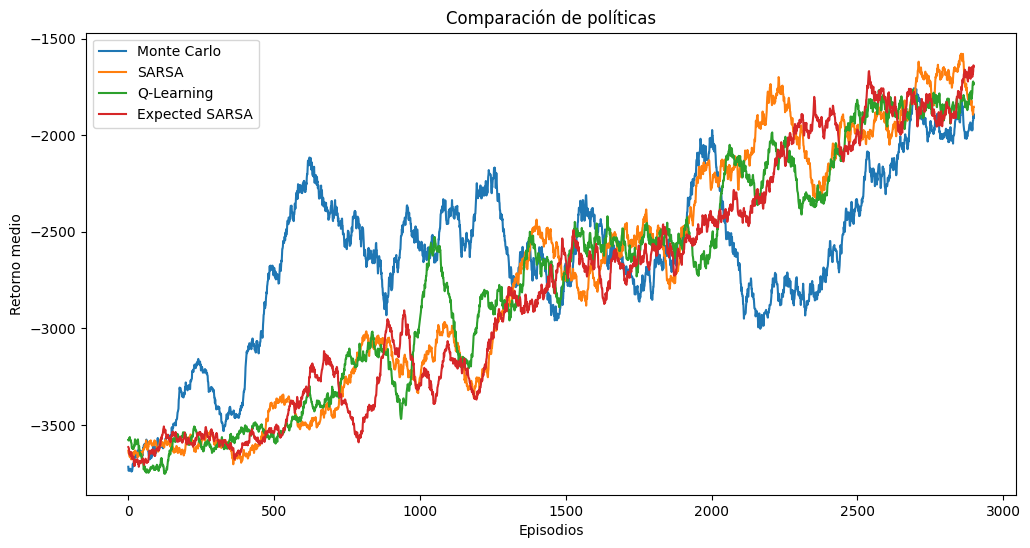

In [80]:
# Hacemos un gráfico de los resultados de las tres políticas
plt.figure(figsize=(12, 6))
plt.plot(resultados_montecarlo, label='Monte Carlo')
plt.plot(resultados_sarsa, label='SARSA')
plt.plot(resultados_q_learning, label='Q-Learning')
plt.plot(resultados_expected_sarsa, label='Expected SARSA')
plt.xlabel('Episodios')
plt.ylabel('Retorno medio')
plt.title('Comparación de políticas')
plt.legend()

plt.show()

- **¿Qué algoritmo obtiene una política determinista más efectiva?**

    Para saber que política es más efectiva, tenemos que observar la política obtenida por cada uno de los algoritmos. En nuestro caso, nos apoyamos de la función `comprueba_politica` para observar la política obtenida por cada uno de los algoritmos con 200 episodios en los cuales no se modifica la política. 

    Si observamos el retorno medio del episodio, podemos ver que el algoritmo que obtiene una política determinista más efectiva es <u>SARSA</u>, con un retorno medio de $-1344.74$

In [82]:
print("Recompensa media Monte Carlo:", round(montecarlo_reward, 2))
print("Recompensa media SARSA:", round(sarsa_reward, 2))
print("Recompensa media Q-Learning:", round(q_learning_reward, 2))
print("Recompensa media Expected SARSA:", round(expected_sarsa_reward, 2))

Recompensa media Monte Carlo: -2099.78
Recompensa media SARSA: -1344.74
Recompensa media Q-Learning: -1468.68
Recompensa media Expected SARSA: -2033.51



- **¿Qué algoritmo obtiene mejor rendimiento como algoritmo de control, es decir, mayores retornos mientras sigue aprendiendo?**

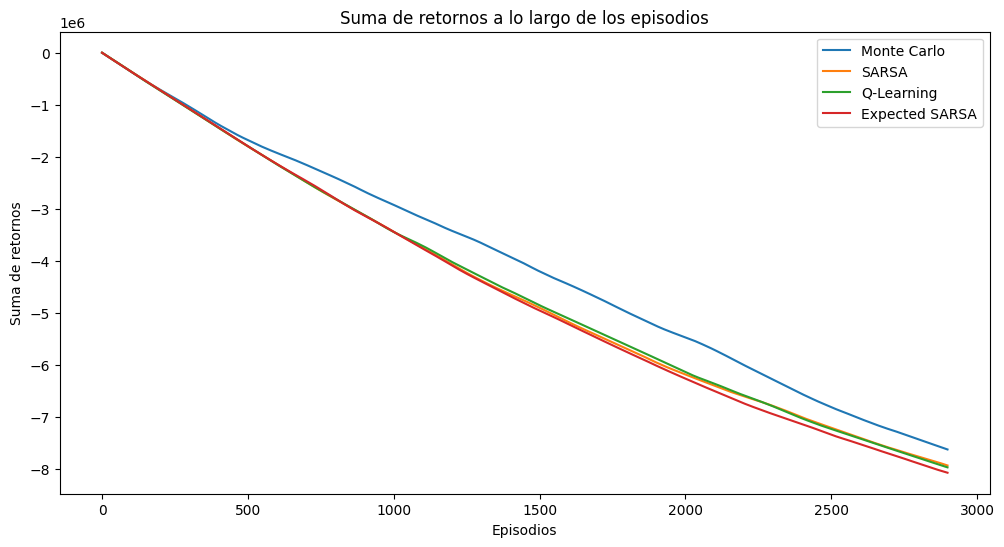

In [83]:
# Qué algoritmo obtiene mejores retornos mientras sigue aprendiendo?
# Calculamos la suma de retornos a lo largo de los episodios
suma_montecarlo = np.cumsum(resultados_montecarlo)
suma_sarsa = np.cumsum(resultados_sarsa)
suma_q_learning = np.cumsum(resultados_q_learning)
suma_expected_sarsa = np.cumsum(resultados_expected_sarsa)

plt.figure(figsize=(12, 6))
plt.plot(suma_montecarlo, label='Monte Carlo')
plt.plot(suma_sarsa, label='SARSA')
plt.plot(suma_q_learning, label='Q-Learning')
plt.plot(suma_expected_sarsa, label='Expected SARSA')
plt.xlabel('Episodios')
plt.ylabel('Suma de retornos')
plt.title('Suma de retornos a lo largo de los episodios')
plt.legend()

plt.show()

- **Conclusión**:

    Para saber que algoritmo obtiene mejor rendimiento como algoritmo de control, es decir, mayores retornos mientras sigue aprendiendo, tenemos que observar el retorno acumulado de cada uno de los algoritmos conforme pasan los episodios.

    Vemos en la gráfica que aunque todos llegan más o menos a un mismo punto, <u>Montecarlo</u> es el que obtiene una menor recompensa acumulada. Este algoritmo tiene mayor variación de retornos medios durante el entrenamiento.

- **Si introducimos perturbaciones, ¿qué algoritmo funciona mejor? ¿Cómo podemos adaptar el aprendizaje para que funcione mejor en este caso?**

In [84]:
# Probamos a ejecutar todos los entornos con perturbaciones
env = gym.make('Pendulum-v1')
politica_montecarlo_perturbada, resultados_montecarlo_perturbada = control_mc(env, 3000, epsilon=0.1, perturbation=True)
politica_sarsa_perturbada, resultados_sarsa_perturbada = sarsa(env, 3000, alpha=0.1, epsilon=0.1, perturbation=True)
politica_q_learning_perturbada, resultados_q_learning_perturbada = q_learning(env, 3000, alpha=0.1, epsilon=0.1, perturbation=True)
politica_expected_sarsa_perturbada, resultados_expected_sarsa_perturbada = expected_sarsa(env, 3000, alpha=0.1, epsilon=0.1, perturbation=True)


Iteración: 100 | Retorno medio últimas 100: -3656.3695497831586
Iteración: 101 | Retorno medio últimas 100: -3650.5963391685677
Iteración: 102 | Retorno medio últimas 100: -3653.728117596358
Iteración: 103 | Retorno medio últimas 100: -3669.9295470902125
Iteración: 104 | Retorno medio últimas 100: -3661.9556303610543
Iteración: 105 | Retorno medio últimas 100: -3673.856738337567
Iteración: 106 | Retorno medio últimas 100: -3681.1027808213826
Iteración: 107 | Retorno medio últimas 100: -3671.763847317819
Iteración: 108 | Retorno medio últimas 100: -3653.3753443326964
Iteración: 109 | Retorno medio últimas 100: -3642.7374281031293
Iteración: 110 | Retorno medio últimas 100: -3631.627141681259
Iteración: 111 | Retorno medio últimas 100: -3641.5692415935687
Iteración: 112 | Retorno medio últimas 100: -3641.52226808563
Iteración: 113 | Retorno medio últimas 100: -3615.5100202957656
Iteración: 114 | Retorno medio últimas 100: -3597.3672758729926
Iteración: 115 | Retorno medio últimas 100: -3

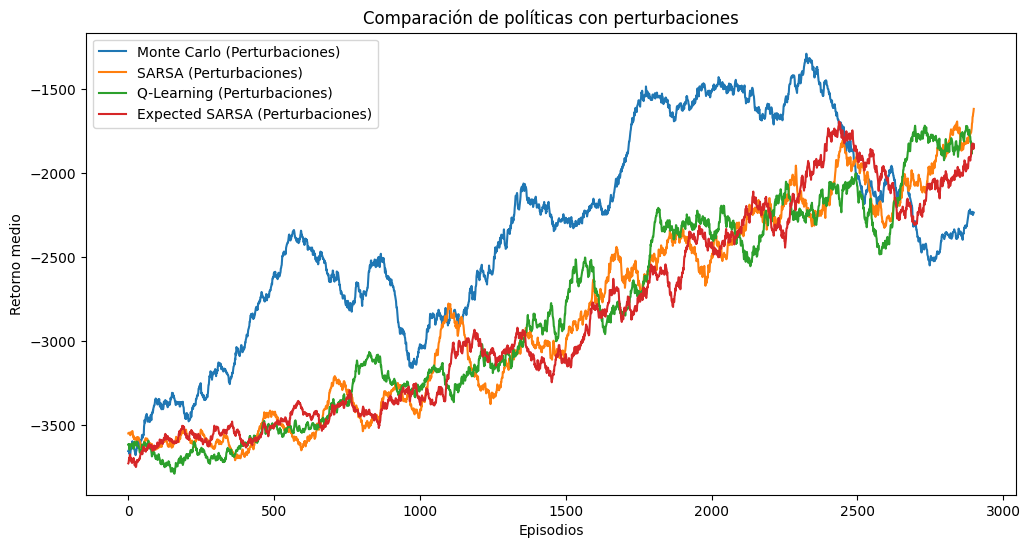

In [85]:
# Hacemos un gráfico de los resultados de las tres políticas
plt.figure(figsize=(12, 6))
plt.plot(resultados_montecarlo_perturbada, label='Monte Carlo (Perturbaciones)')
plt.plot(resultados_sarsa_perturbada, label='SARSA (Perturbaciones)')
plt.plot(resultados_q_learning_perturbada, label='Q-Learning (Perturbaciones)')
plt.plot(resultados_expected_sarsa_perturbada, label='Expected SARSA (Perturbaciones)')
plt.xlabel('Episodios')
plt.ylabel('Retorno medio')
plt.title('Comparación de políticas con perturbaciones')
plt.legend()

plt.show()

Comprobamos las políticas cuando hay perturbaciones:

Política Monte Carlo con perturbaciones:


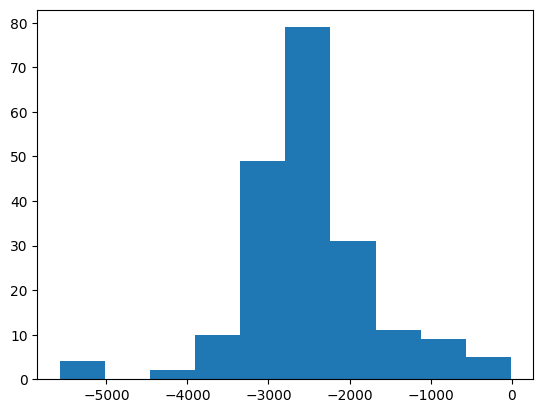

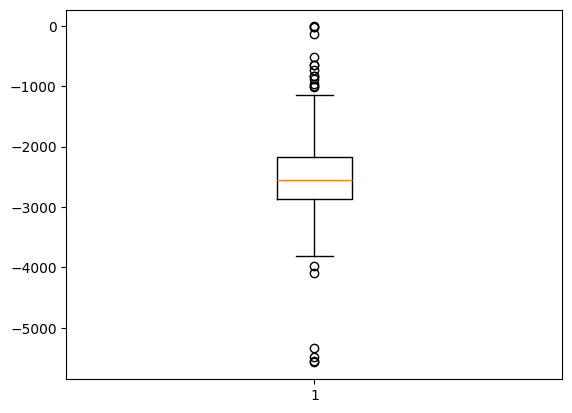

Recompensa media: -2490.060528456014
Política Q-Learning con perturbaciones:
Recompensa promedio: -1851.86
Política SARSA con perturbaciones:
Recompensa promedio: -2673.03
Política Expected SARSA con perturbaciones:
Recompensa promedio: -1555.89


In [ ]:
# Comprobamos la política Monte Carlo con perturbaciones
print("Política Monte Carlo con perturbaciones:")
comprueba_politica(env, politica_montecarlo_perturbada)
# Comprobamos la política Q-Learning con perturbaciones
print("Política Q-Learning con perturbaciones:")
comprueba_politica_greedy(env, politica_q_learning_perturbada)
# Comprobamos la política SARSA con perturbaciones
print("Política SARSA con perturbaciones:")
comprueba_politica_greedy(env, politica_sarsa_perturbada)
# Comprobamos la política Expected SARSA con perturbaciones
print("Política Expected SARSA con perturbaciones:")
comprueba_politica_greedy(env, politica_expected_sarsa_perturbada)

- **Conclusión**:

    En el caso de introducir perturbaciones, el algoritmo que parece funcionar mejor es <u>Expected SARSA</u>, ya que suaviza el impacto del ruido al calcular la expectativa sobre todas las acciones posibles. Para mejorar su rendimiento en este contexto, lo ideal sería utilizar un valor de _alpha_ bajo o adaptativo, reduciendo la variabilidad en las actualizaciones y aumentando la estabilidad del aprendizaje.

    **¿Qué se debe cambiar para mejorar con perturbaciones?**

    **Nota**: *Las perturbaciones tal y como se definen lo que hacen es aumentar la exploración a valores extremos de acciones*.

    - Disminuir alpha para que las actualizaciones no sean tan sensibles
    - Incrementar epsilon para que no se exploren solo esas acciones extremas, reforzando la exploración general. Siempre buscamos el equilibrio entre exploración y explotación.